# Simple denoising autoencoder example

A denoising autoencoder implemented in Keras and trained on MNIST. 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
np.random.seed(1337)

In [4]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.noise import GaussianNoise, GaussianDropout

Using Theano backend.


In [5]:
batch_size = 100
nb_epoch = 15

## Load the MNIST dataset

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

60000 train samples
10000 test samples


## Preprocess the data
We're going to use tanh non-linearities. This means that the network outputs values between -1 and +1. We generate target variables in the same range.

In [8]:
Y_train = X_train / 128.0 - 1.0
Y_test = X_test / 128.0 - 1.0

The hidden units also use tanh nonlinearities. We would therefore like our input data to be zero centered so that most (but not all) of the values are in the linear part of the tanh. This will ensure our gradients flow nicely. However, we want to also make sure that some of the values are outside the linear part so that we don't end up with an almost linear classifier. Standardizing the features by removing the mean and scaling to unit variance is a good way to achieve this.

In [10]:
X_mean = X_train.mean()
X_std = X_train.std()

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

## Define our denoising autoencoder model

This is a feedforward model with a single hidden layer consisting of 200 hidden units. Tanh units are used for both the hidden and output layers. We add dropout noise with $p = 0.5$ to the inputs, which sets the input pixels to zero with a probability of 0.3. You can also use Gaussian noise, which gives similar results. Note that noise is not added during validation, only during training.

In [226]:
class TiedDense(Dense):
    def __init__(self, output_dim, transposed_layer=None, **kwargs):
        self.output_dim = output_dim
        self.transposed_layer = transposed_layer
        Dense.__init__(self, output_dim, **kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        output = self.activation(K.dot(X, self.transposed_layer.W.T) + self.b)
        return output


model = Sequential()

# noise
model.add(Dropout(0.5, input_shape=(784,)))
#model.add(GaussianNoise(1.0, input_shape=(784,)))

# encoder
encoder = Dense(200, activation='tanh') 
model.add(encoder)#, weights=[W_initial, b_initial]))

# decoder
decoder = TiedDense(784, transposed_layer=encoder, activation='tanh')
model.add(decoder)
#model.add(Dense(784, W_regularizer='l2', activation='tanh'))

In [227]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dropout_9 (Dropout)                (None, 784)         0           dropout_input_9[0][0]            
____________________________________________________________________________________________________
dense_20 (Dense)                   (None, 200)         157000      dropout_9[0][0]                  
____________________________________________________________________________________________________
tieddense_12 (TiedDense)           (None, 784)         157584      dense_20[0][0]                   
Total params: 314584
____________________________________________________________________________________________________


## Fit the model

Here we use the Adam optimizer, which works a little better than SGD on this problem. We train for 15 epochs using the default learning rate and Euclidean loss.

In [228]:
#opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam()
model.compile(loss='mean_squared_error', optimizer=opt)

In [229]:
history = model.fit(
    X_train, Y_train, 
    batch_size=batch_size, 
    nb_epoch=15,
    verbose=2, 
    validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
8s - loss: 0.1282 - val_loss: 0.0552
Epoch 2/15
8s - loss: 0.0748 - val_loss: 0.0442
Epoch 3/15
8s - loss: 0.0674 - val_loss: 0.0390
Epoch 4/15
8s - loss: 0.0621 - val_loss: 0.0360
Epoch 5/15
10s - loss: 0.0578 - val_loss: 0.0331
Epoch 6/15
9s - loss: 0.0542 - val_loss: 0.0314
Epoch 7/15
9s - loss: 0.0516 - val_loss: 0.0299
Epoch 8/15
10s - loss: 0.0497 - val_loss: 0.0292
Epoch 9/15
8s - loss: 0.0484 - val_loss: 0.0283
Epoch 10/15
10s - loss: 0.0474 - val_loss: 0.0276
Epoch 11/15
11s - loss: 0.0467 - val_loss: 0.0274
Epoch 12/15
10s - loss: 0.0461 - val_loss: 0.0266
Epoch 13/15
10s - loss: 0.0458 - val_loss: 0.0274
Epoch 14/15
10s - loss: 0.0453 - val_loss: 0.0268
Epoch 15/15
10s - loss: 0.0451 - val_loss: 0.0259


## Visualize the learned filters

We visualize the weights of the first 100 learned filters by scaling them to 0, 1 and rendering them on a grid.

In [230]:
def tile_filters(filters, image_shape=(28, 28), tile_shape=(10, 10), tile_spacing=(1, 1)):
    h, w = image_shape
    r, c = tile_shape
    sy, sx = tile_spacing
    
    # zero-one normalize filters
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    
    filters = filters.reshape(h, w, -1)
    result = np.zeros((r * (h + sy) - sy, c * (w + sx) - sx))
    index = 0
    for i in xrange(r):
        for j in xrange(c):
            filt = filters[:, :, index]
            i_start = i * (h + sy)
            i_end = i_start + h
            j_start = j * (w + sx)
            j_end = j_start + w 
            result[i_start:i_end, j_start:j_end] = filt
            index += 1
    return result
            

(784, 200)


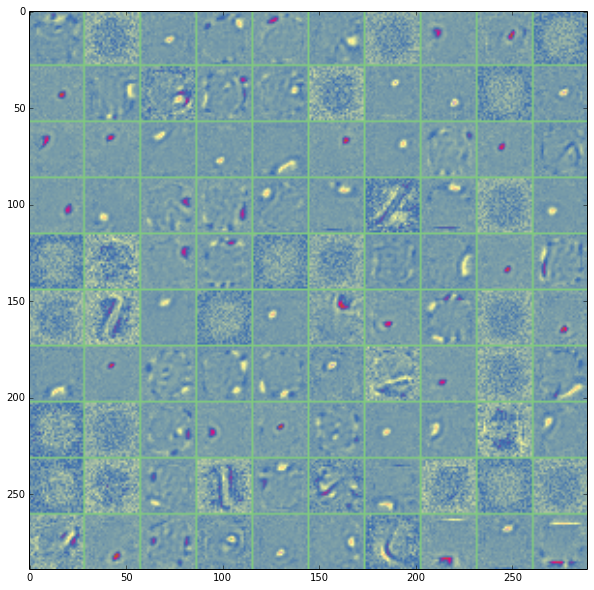

In [231]:
W1 = model.get_weights()[0]
print W1.shape
figure(figsize=(10,10))
imshow(tile_filters(W1), cmap=cm.Accent)

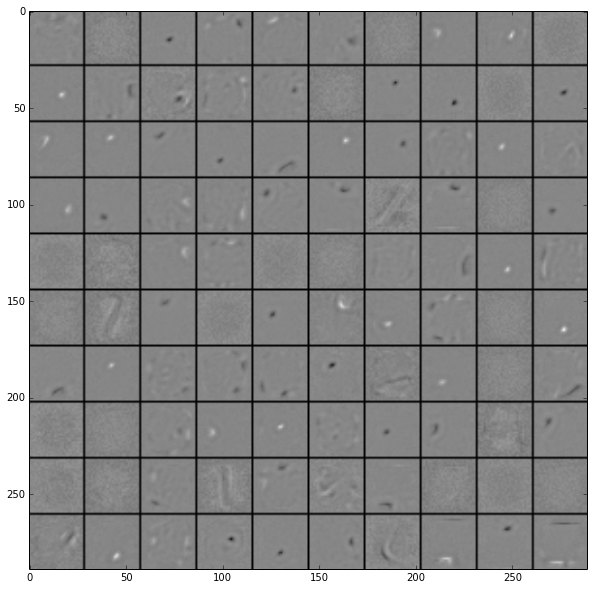

In [232]:
W1 = model.get_weights()[0]
figure(figsize=(10,10))
imshow(tile_filters(W1), cmap=cm.gray)

# Encode-decode

Let's encode and decode a random sample from the validation set to get an idea how good the reconstruction is.
    

In [233]:
X_sample = X_test[100:200,:]

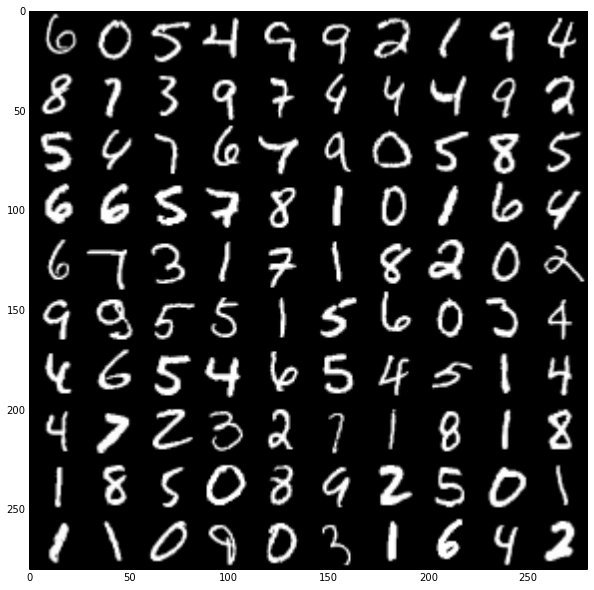

In [234]:
z = X_sample.reshape(10, 10, 28, 28).transpose(0,2,1,3).reshape(10*28, 10*28)
figure(figsize=(10,10))
imshow(z)

In [235]:
X_decoded = model.predict(X_sample)

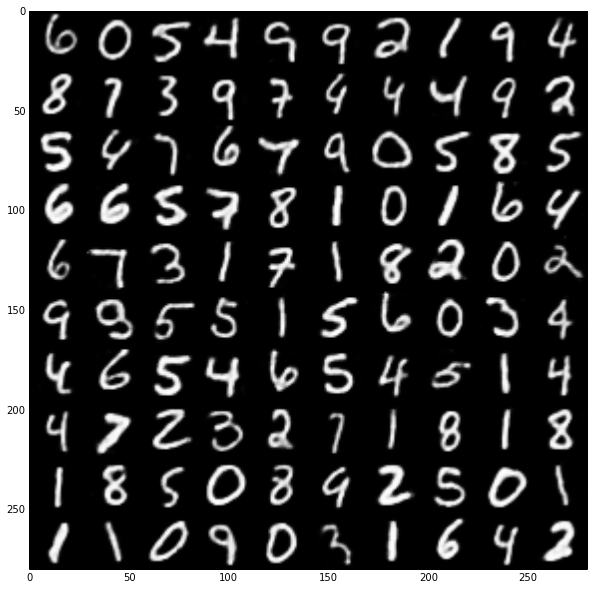

In [236]:
z = X_decoded.reshape(10, 10, 28, 28).transpose(0, 2, 1, 3).reshape(10*28, 10*28)
figure(figsize=(10,10))
imshow(z)

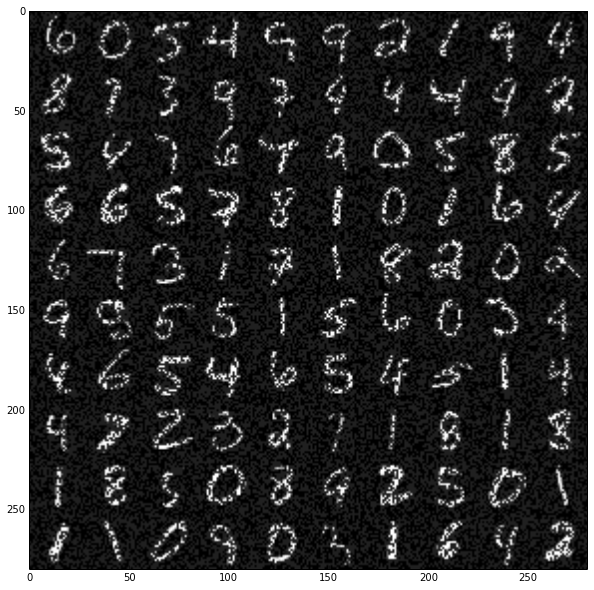

In [237]:
X_noisy = X_sample.copy()
X_noisy.flat[np.random.rand(len(X_noisy.flat)) < 0.5] = 0
#X_noisy = X_noisy + np.random.randn(*X_noisy.shape)
z = X_noisy.reshape(10, 10, 28, 28).transpose(0, 2, 1, 3).reshape(10*28, 10*28)
figure(figsize=(10,10))
imshow(z)

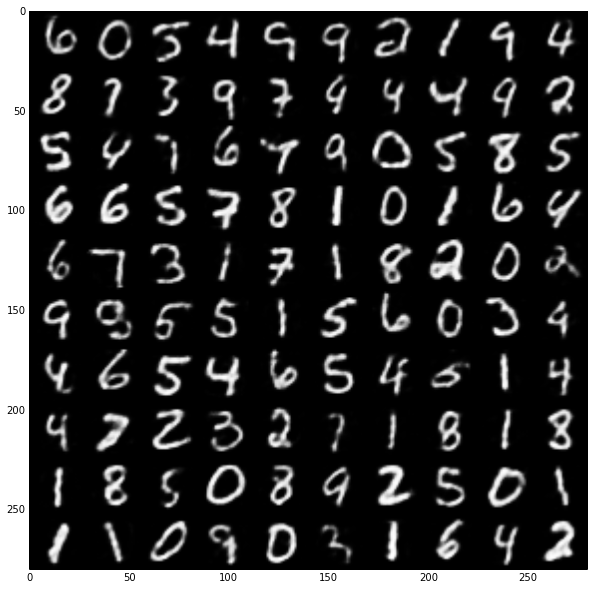

In [238]:
X_decoded = model.predict(X_noisy)
z = X_decoded.reshape(10, 10, 28, 28).transpose(0, 2, 1, 3).reshape(10*28, 10*28)
figure(figsize=(10,10))
imshow(z)